In [1]:
import json
import os
import ml_collections
from lightning.pytorch import seed_everything
from seisLM.model.foundation.pretrained_models import LitMultiDimWav2Vec2
from seisLM.data_pipeline import collator
from seisLM.data_pipeline import seisbench_dataloaders as dataloaders
import matplotlib.pyplot as plt
import tqdm

DEFAULT_NUM_WORKERS = 4


def get_config():
  config_path = '/home/liu0003/Desktop/projects/seisLM/seisLM/configs/pretrain/pretrain_config_layernorm_std_small_batch_4_datasets_less_regularized.json'
  with open(config_path, "r", encoding="utf-8") as f:
    config = json.load(f)
  config = ml_collections.ConfigDict(config)
  config.data_config.local_batch_size = 128
  assert config.data_config.amp_norm_type == 'std'

  config.data_config.num_workers = int(
      os.environ.get('SLURM_CPUS_PER_TASK', DEFAULT_NUM_WORKERS))
  return config


/home/liu0003/miniconda3/envs/seisbench/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Check if the first batch has extreme values 

Seed set to 42


Processing NEIC
idx 52 max_input_values: 14999999488.0


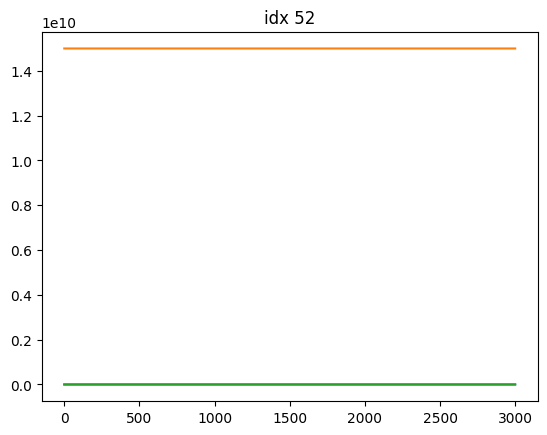

In [5]:
data_name = 'NEIC'

config = get_config()
seed_everything(config.seed)
model = LitMultiDimWav2Vec2(config)


data_collator = \
  collator.DataCollatorForWav2Vec2PretrainingConcatChannelsNoPadding(
      config=config.model_config,
      mask_time_prob=config.training_config.mask_time_prob,
      mask_time_length=config.training_config.mask_time_length,
  )


print(f'Processing {data_name}')
train_loader, dev_loader = dataloaders.prepare_seisbench_dataloaders(
  model=model,
  training_fraction=config.data_config.training_fraction,
  data_names=[data_name],
  batch_size=config.data_config.local_batch_size,
  num_workers=config.data_config.num_workers,
  prefetch_factor=config.data_config.prefetch_factor,
  collator=data_collator,
  cache=config.data_config.cache_dataset,
)


max_input_values = 0.0
# batch = next(iter(train_loader))
batch = next(iter(dev_loader))
input_values = batch['input_values']


extreme_value_indices = []
for idx in range(input_values.shape[0]):
  if input_values[idx].abs().max().item() > 100:
    extreme_value_indices.append(idx)
    print(f'idx {idx} max_input_values: {input_values[idx].abs().max().item()}')
    plt.figure()
    plt.plot(input_values[idx].T)
    plt.title(f'idx {idx}')


# Reference: without normalization

Seed set to 42


Processing NEIC
idx 31 max_input_values: 100872.0390625
idx 45 max_input_values: 49094.7265625
idx 58 max_input_values: 128793.1015625
idx 91 max_input_values: 88460.1640625
idx 92 max_input_values: 7182617.0
idx 93 max_input_values: 41629.8515625
idx 94 max_input_values: 50072.46875
idx 95 max_input_values: 4821145.5
idx 102 max_input_values: 8506.3154296875
idx 117 max_input_values: 127301.125
idx 118 max_input_values: 33924.296875


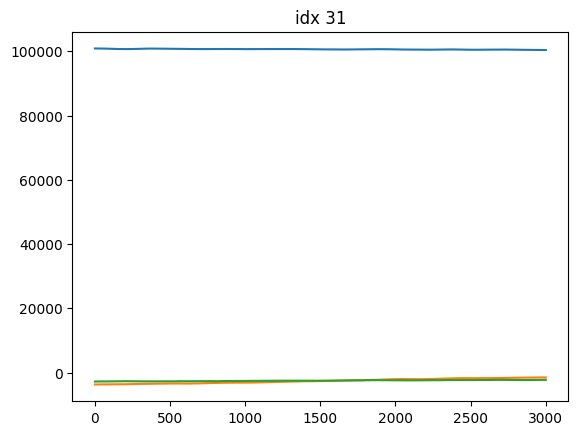

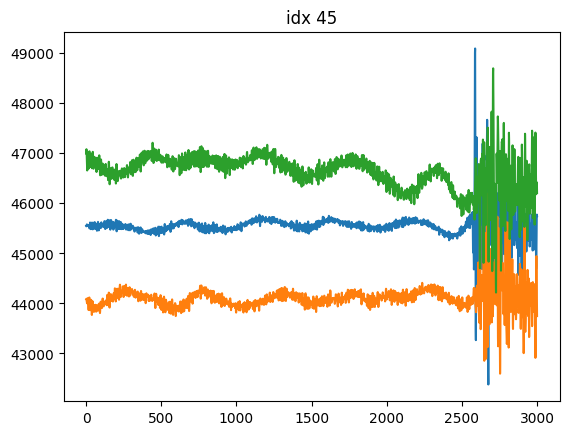

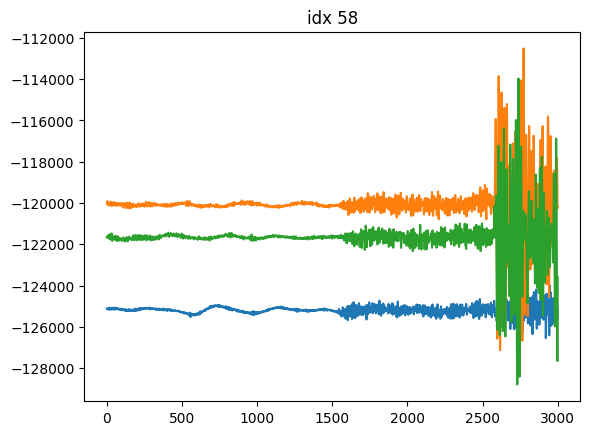

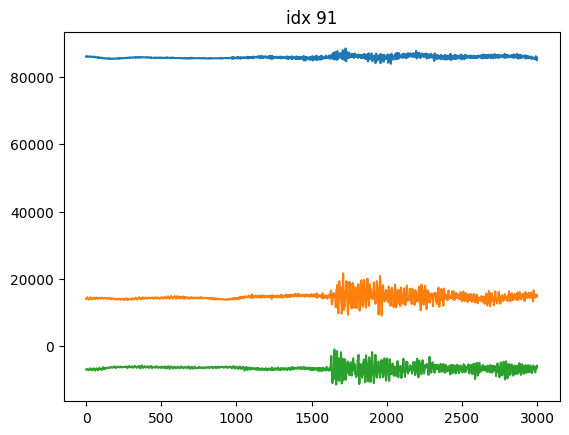

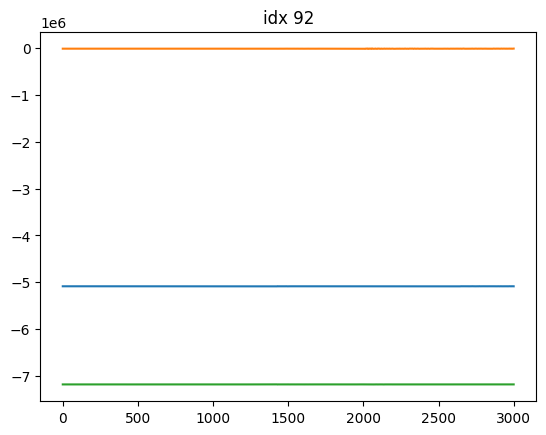

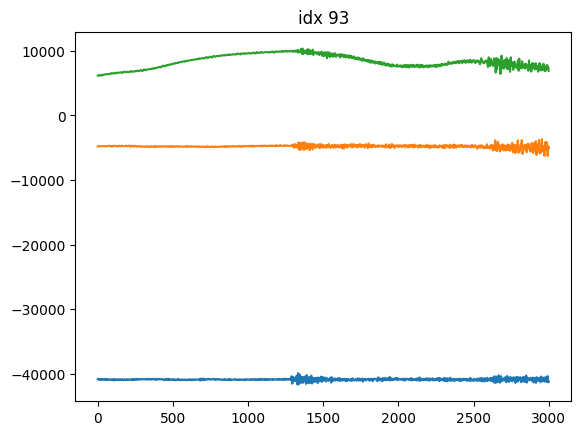

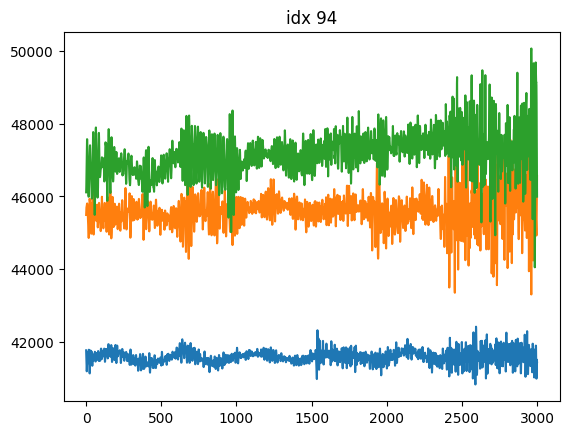

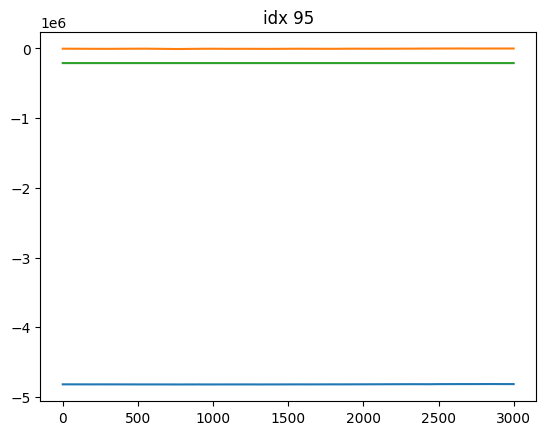

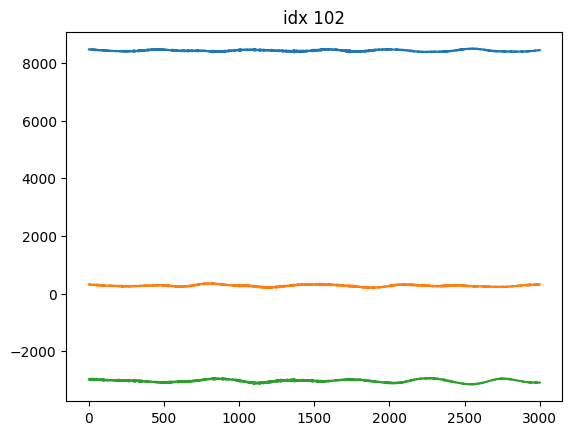

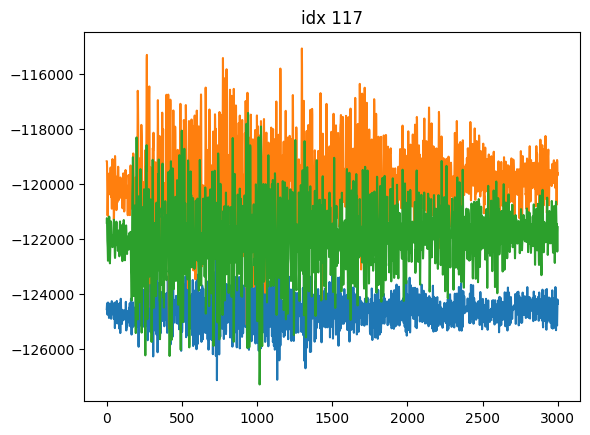

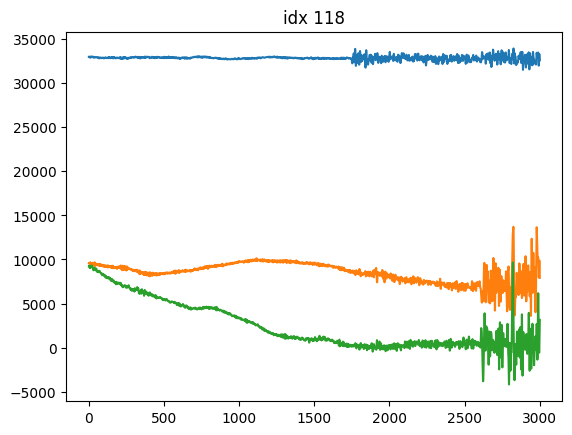

In [7]:

data_name = 'NEIC'

config = get_config()
config.data_config.demean = False
config.data_config.amp_norm = False
config.data_config.amp_norm_type = 'peak'


seed_everything(config.seed)
model = LitMultiDimWav2Vec2(config)


data_collator = \
  collator.DataCollatorForWav2Vec2PretrainingConcatChannelsNoPadding(
      config=config.model_config,
      mask_time_prob=config.training_config.mask_time_prob,
      mask_time_length=config.training_config.mask_time_length,
  )


print(f'Processing {data_name}')
train_loader, dev_loader = dataloaders.prepare_seisbench_dataloaders(
  model=model,
  training_fraction=config.data_config.training_fraction,
  data_names=[data_name],
  batch_size=config.data_config.local_batch_size,
  num_workers=config.data_config.num_workers,
  prefetch_factor=config.data_config.prefetch_factor,
  collator=data_collator,
  cache=config.data_config.cache_dataset,
)


max_input_values = 0.0
batch = next(iter(train_loader))
input_values = batch['input_values']


for idx in extreme_value_indices:
  print(f'idx {idx} max_input_values: {input_values[idx].abs().max().item()}')
  plt.figure()
  plt.plot(input_values[idx].T)
  plt.title(f'idx {idx}')